In [49]:
# Following "Build a Retrieval Augmented Generation (RAG) App: Part 1"

# 1. install LangChain packages "https://python.langchain.com/docs/how_to/installation/"

# 2. Indexing
# 2.1 Loading documents
from langchain_community.document_loaders import WebBaseLoader
import bs4

loader = WebBaseLoader(
    web_paths=("https://time.com/7274651/why-economists-are-horrified-by-trump-tariff-math/",
               "https://www.bbc.com/news/articles/cn93e12rypgo",
               "https://www.bbc.com/news/articles/cp92r2kvk74o",
               "https://www.ft.com/content/a18ed1bd-3546-453a-bf11-72b5ac6a56f5",
               "https://www.euractiv.com/section/economy-jobs/news/uk-lands-deal-to-duck-some-trump-tariffs/",
               "https://www.theguardian.com/world/2025/may/09/china-exports-beat-expectations-despite-slump-in-trade-with-us",
               "https://www.investors.com/news/trump-tariffs-apple-amazon-gm-saying/"), # News on APR 3., May 8. and May 9. 2025 
    
    bs_kwargs=dict(
    parse_only=bs4.SoupStrainer("article")
)
)

# Add a print statement to verify the raw content if docs is unexpectedly empty
docs = loader.load()
print(docs[0].page_content[:100])  # Preview first 100 chars from 1st news paper
print(docs[1].page_content[:100])  # Preview first 100 chars from 2nd news paper
print(docs[2].page_content[:100])  # Preview first 100 chars from 3rd new paper
print(docs[3].page_content[:100])  # Preview first 100 chars from 4th new paper
print(docs[4].page_content[:100])  # Preview first 100 chars from 5th new paper
print(docs[5].page_content[:100])  # Preview first 100 chars from 6th new paper
print(docs[6].page_content[:100])  # Preview first 100 chars from 7th new paper

When President Donald Trump initially announced his new tariffs in February, he proposed them as a “
What tariffs has Trump announced and why?1 day agoShareSaveJennifer ClarkeBBC NewsShareSaveReutersA 
US and UK agree deal slashing Trump tariffs on cars and metals21 hours agoShareSaveNatalie ShermanBB
If tariffs punish exports as much as imports, it is obviously futile to use them to address a suppos






The limited pact leaves plenty of space for a more ambitious deal with the EU later this month
 A cargo train moves past new cars waiting for shipment in a port in Yantai in east China's Shandong



News 
	  What Apple, Amazon, GM And Other Companies Are Saying About Trump Tariffs	



 Licensing


In [53]:
# 2.2 Splitting documents
from langchain_text_splitters import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=900,  # chunk size (characters), (> 50 chunks)
    chunk_overlap=200,  # chunk overlap (characters)
    add_start_index=True,  # track index in original document
)
all_splits = text_splitter.split_documents(docs)

print(f"Split blog post into {len(all_splits)} sub-documents.")

Split blog post into 61 sub-documents.


In [3]:
# 2.3 Storing documents 

# document_ids = vector_store.add_documents(documents=all_splits)
# (Vector Store = ChromaDB: Vector databases efficiently store, manage, and retrieve dense embeddings at scale.
# we'll use ChromaDB to store both embeddings and documents, and perform a semantic search with document retrieval.)
# As following, we need to import the LangSmith as os.environ and install ChromaDB pakage.

In [54]:
# 3. use LangSmith
import getpass
import os

os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_API_KEY"] = getpass.getpass()

In [55]:
# Configure environment to connect to LangSmith.
os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_ENDPOINT"]="https://api.smith.langchain.com"
os.environ["LANGSMITH_PROJECT"]="RAGsystemProjekt_Wenwen"


In [56]:
# 4. Components
# 4.1 Select chat model: Google Gemini

import getpass
import os

if not os.environ.get("GOOGLE_API_KEY"):
  os.environ["GOOGLE_API_KEY"] = getpass.getpass("Enter API key for Google Gemini: ")

from langchain.chat_models import init_chat_model

llm = init_chat_model("gemini-2.0-flash", model_provider="google_genai")

In [57]:
# 4.2 Select embedding model: HuggingFace
from langchain_huggingface import HuggingFaceEmbeddings

embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-mpnet-base-v2")

In [58]:
# 4.3 Select vector store: Chroma (install and upgrade langchain_chroma)
from langchain_chroma import Chroma

vector_store = Chroma(
    collection_name="example_collection",
    embedding_function=embeddings,
    persist_directory="./chroma_langchain_db",  # Where to save data locally, remove if not necessary
)

In [59]:
# 2.3 Storing documents
document_ids = vector_store.add_documents(documents=all_splits)

print(document_ids[:3])

['6d8cda27-b2ce-489b-bf7c-39b37baa74fe', '145be583-362a-4aac-83f8-d9e6313e0b4b', '3d7e142e-5f7c-40e1-b3f2-4ab687751ee4']


In [10]:
# 4.4 Dependencies: needed for management of a chat history.
# pip install --upgrade langgraph langchain-community beautifulsoup4

In [60]:
# 5. Retrieval and Generation: Now write the actual application logic
# For generation, we use the chat model "gemini-2.0-flash"

# use a prompt for RAG that is checked into the LangChain prompt hub
from langchain import hub

prompt = hub.pull("rlm/rag-prompt")

example_messages = prompt.invoke(
    {"context": "(context goes here)", "question": "(question goes here)"}
).to_messages()

assert len(example_messages) == 1
print(example_messages[0].content)

You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
Question: (question goes here) 
Context: (context goes here) 
Answer:


In [61]:
# use LangGraph to tie together the retrieval and generation steps into a single application. 
# 5.1 State: For a simple RAG application, we can just keep track of the input question, retrieved context, and generated answer
from langchain_core.documents import Document
from typing_extensions import List, TypedDict


class State(TypedDict):
    question: str
    context: List[Document]
    answer: str

In [62]:
# 5.2 Prompt variations (Customizing the prompt): we can load prompts from the prompt hub, or customize it.
from langchain_core.prompts import PromptTemplate

template = """Use the following pieces of context to answer the question at the end.
If you don't know the answer, just say that you don't know, don't try to make up an answer.
Use three sentences maximum and keep the answer as concise as possible.
Always say "thanks for asking!" at the end of the answer.

{context}

Question: {question}

Helpful Answer:"""
prompt = PromptTemplate.from_template(template)

In [63]:
# we will have:
# 1) User input as a HumanMessage;
# 2) Vector store query as an AIMessage with tool calls;
# 3) Retrieved documents as a ToolMessage;
# 4) Final response as a AIMessage.
# This model for state is so versatile that LangGraph offers a built-in version for convenience:
from langgraph.graph import MessagesState, StateGraph

graph_builder = StateGraph(MessagesState)

In [64]:
# 5.3 Nodes (application steps)
# Following "Build a Retrieval Augmented Generation (RAG) App: Part 2"

# In a conversational setting, user queries may require contextualization based on the chat history.
# turn our retrieval step into creating tools:
from langchain_core.tools import tool


@tool(response_format="content_and_artifact")
def retrieve(query: str):
    """Retrieve information related to a query."""
    retrieved_docs = vector_store.similarity_search(query, k=2)
    serialized = "\n\n".join(
        (f"Source: {doc.metadata}\n" f"Content: {doc.page_content}")
        for doc in retrieved_docs
    )
    return serialized, retrieved_docs

# Our graph will consist of three nodes:
# 1) A node that fields the user input, either generating a query for the retriever or responding directly;
# 2) A node for the retriever tool that executes the retrieval step;
# 3) A node that generates the final response using the retrieved context.

from langchain_core.messages import SystemMessage
from langgraph.prebuilt import ToolNode


# Step 1: Generate an AIMessage that may include a tool-call to be sent.
def query_or_respond(state: MessagesState):
    """Generate tool call for retrieval or respond."""
    llm_with_tools = llm.bind_tools([retrieve])
    response = llm_with_tools.invoke(state["messages"])
    # MessagesState appends messages to state instead of overwriting
    return {"messages": [response]}


# Step 2: Execute the retrieval.
tools = ToolNode([retrieve])


# Step 3: Generate a response using the retrieved content.
def generate(state: MessagesState):
    """Generate answer."""
    # Get generated ToolMessages
    recent_tool_messages = []
    for message in reversed(state["messages"]):
        if message.type == "tool":
            recent_tool_messages.append(message)
        else:
            break
    tool_messages = recent_tool_messages[::-1]

    # Format into prompt
    docs_content = "\n\n".join(doc.content for doc in tool_messages)
    system_message_content = (
        "You are an assistant for question-answering tasks. "
        "Use the following pieces of retrieved context to answer "
        "the question. If you don't know the answer, say that you "
        "don't know. Use three sentences maximum and keep the "
        "answer concise."
        "\n\n"
        f"{docs_content}"
    )
    conversation_messages = [
        message
        for message in state["messages"]
        if message.type in ("human", "system")
        or (message.type == "ai" and not message.tool_calls)
    ]
    prompt = [SystemMessage(system_message_content)] + conversation_messages

    # Run
    response = llm.invoke(prompt)
    return {"messages": [response]}



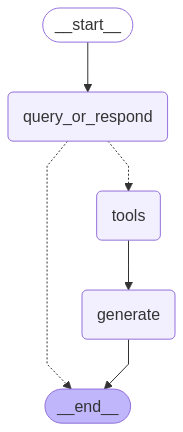

In [65]:
# 5.4 Control flow: compile our application into a single graph object.
from langgraph.graph import END
from langgraph.prebuilt import tools_condition

graph_builder.add_node(query_or_respond)
graph_builder.add_node(tools)
graph_builder.add_node(generate)

graph_builder.set_entry_point("query_or_respond")
graph_builder.add_conditional_edges(
    "query_or_respond",
    tools_condition,
    {END: END, "tools": "tools"},
)
graph_builder.add_edge("tools", "generate")
graph_builder.add_edge("generate", END)

graph = graph_builder.compile()

from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [66]:
# Multi-turn interaction & Memory
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()
graph = graph_builder.compile(checkpointer=memory)

# Specify an ID for the thread
config = {"configurable": {"thread_id": "abc123"}}

In [67]:
# 5.5 Usage: test our application
# Question 1: simple question, which can be directly found in the text.
input_message = "When Trump initially announced his new tariffs in February, what did he propose?"

# Stream with required configuration
for step in graph.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
    config={
        "configurable": {
            "thread_id": "thread_123",  # or any unique identifier
            # You can also use "checkpoint_ns" or "checkpoint_id" instead
        }
    }
):
    step["messages"][-1].pretty_print()



================================ Human Message =================================

When Trump initially announced his new tariffs in February, what did he propose?
================================== Ai Message ==================================
Tool Calls:
  retrieve (e7440e8b-ad51-42f6-9be0-ee66ac7cee20)
 Call ID: e7440e8b-ad51-42f6-9be0-ee66ac7cee20
  Args:
    query: what tariffs did trump announce in february
================================= Tool Message =================================
Name: retrieve

Source: {'source': 'https://www.bbc.com/news/articles/cn93e12rypgo', 'start_index': 1403}
Content: taken advantage of by "cheaters" and "pillaged" by foreigners.The US president has made other demands alongside tariffs. When he announced the first tariffs of his current term against China, Mexico and Canada, he said he wanted them to do more to stop migrants and illegal drugs reaching the US. What tariffs has Trump announced?China: Chinese imports to the US include everything from i

In [73]:
# Question 2: user ask 2 questions at once
input_message = "Whether all the countries over the world get the same tariff? If not, which countries get different than 10%? please list them."

# Stream with required configuration
for step in graph.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
    config={
        "configurable": {
            "thread_id": "thread_123",  # or any unique identifier
            # You can also use "checkpoint_ns" or "checkpoint_id" instead
        }
    }
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

Whether all the countries over the world get the same tariff? If not, which countries get different than 10%? please list them.
================================== Ai Message ==================================
Tool Calls:
  retrieve (47e063bb-77f2-4ad8-a44e-0a7e95ceb1b7)
 Call ID: 47e063bb-77f2-4ad8-a44e-0a7e95ceb1b7
  Args:
    query: list of countries with tariffs different than 10% imposed by the US
================================= Tool Message =================================
Name: retrieve

Source: {'description': '"These are not reciprocal tariffs in their true meaning," argues one associate professor of economics.', 'language': 'en', 'source': 'https://time.com/7274651/why-economists-are-horrified-by-trump-tariff-math/', 'start_index': 803, 'title': "Why Economists Are Horrified by Trump's Tariff Math | TIME"}
Content: and on places with which the U.S. runs a surplus, such as the U.K.Advertisement

In [69]:
# Question 3: ask somethong based one the previous answer
input_message = "Which country get the highest tariff?"

# Stream with required configuration
for step in graph.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
    config={
        "configurable": {
            "thread_id": "thread_123",  # or any unique identifier
            # You can also use "checkpoint_ns" or "checkpoint_id" instead
        }
    }
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

Which country get the highest tariff?
================================== Ai Message ==================================
Tool Calls:
  retrieve (d43aed27-878f-4bb0-8200-641054736b8f)
 Call ID: d43aed27-878f-4bb0-8200-641054736b8f
  Args:
    query: which country get the highest tariff from the US
================================= Tool Message =================================
Name: retrieve

Source: {'source': 'https://www.bbc.com/news/articles/cn93e12rypgo', 'start_index': 2103}
Content: $800 ended on 2 May. Shipments now face 90% duty or $75 per item - increasing to $150 per item after 1 June.In response to Trump's measures, China has introduced 125% tariffs on US imports.Trump also imposed significant tariffs on China during his first presidential term. These were expanded by his successor Joe Biden, which cut the amount America imports from Beijing. But the US still buys much more from China ($440bn) th

In [ ]:
# Question 4: check its memory
input_message = "Can you repeat the last question?"

# Stream with required configuration
for step in graph.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
    config={
        "configurable": {
            "thread_id": "thread_123",  # or any unique identifier
            # You can also use "checkpoint_ns" or "checkpoint_id" instead
        }
    }
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

Can you repeat the last question?
================================== Ai Message ==================================

Which country gets the highest tariff?


In [74]:
# Question 5: user ask a question that is not in the text
input_message = "Did you know, why USA charge Vietnam so high? and how much tariff does Vietnam charge USA?"

# Stream with required configuration
for step in graph.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
    config={
        "configurable": {
            "thread_id": "thread_123",  # or any unique identifier
            # You can also use "checkpoint_ns" or "checkpoint_id" instead
        }
    }
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

Did you know, why USA charge Vietnam so high? and how much tariff does Vietnam charge USA?
================================== Ai Message ==================================
Tool Calls:
  retrieve (253ecb39-a6da-4b7c-97fe-7d2542f77b33)
 Call ID: 253ecb39-a6da-4b7c-97fe-7d2542f77b33
  Args:
    query: why USA charge Vietnam so high tariff?
  retrieve (d3568fc6-eab2-468b-9f41-ea6415262eff)
 Call ID: d3568fc6-eab2-468b-9f41-ea6415262eff
  Args:
    query: how much tariff does Vietnam charge USA?
================================= Tool Message =================================
Name: retrieve

Source: {'source': 'https://time.com/7274651/why-economists-are-horrified-by-trump-tariff-math/', 'start_index': 2794}
Content: deficit in Vietnam shrinks over the next year. Well, then the tariff rate also should change. But now market participants need to forecast how much the trade deficit with individual countries will 

In [78]:
# Question 6: ask for a summary
input_message = "Please give me a summary on: What Companies Are Saying About Trump Tariffs?"

# Stream with required configuration
for step in graph.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
    config={
        "configurable": {
            "thread_id": "thread_123",  # or any unique identifier
            # You can also use "checkpoint_ns" or "checkpoint_id" instead
        }
    }
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

Please give me a summary on: What Companies Are Saying About Trump Tariffs?
================================== Ai Message ==================================
Tool Calls:
  retrieve (ba96480d-02d0-4374-8904-2368605aca77)
 Call ID: ba96480d-02d0-4374-8904-2368605aca77
  Args:
    query: summary of What Companies Are Saying About Trump Tariffs?
================================= Tool Message =================================
Name: retrieve

Source: {'source': 'https://www.investors.com/news/trump-tariffs-apple-amazon-gm-saying/', 'start_index': 3}
Content: News 
	  What Apple, Amazon, GM And Other Companies Are Saying About Trump Tariffs	



 Licensing


IBD STAFF
08:00 AM ET 05/09/2025




As President Donald Trump reorders the global economic system, investors have been looking to earnings guidance and commentary to understand the actual impact of his administration's tariffs. But companies themselves are tr

In [80]:
# Question 7: ask for a summary from many news papers
input_message = "Please give me a summary on: What are the reactions from China and UK, respectively, toward to Trump's Tariff?"

# Stream with required configuration
for step in graph.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
    config={
        "configurable": {
            "thread_id": "thread_123",  # or any unique identifier
            # You can also use "checkpoint_ns" or "checkpoint_id" instead
        }
    }
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

Please give me a summary on: What are the reactions from China and UK, respectively, toward to Trump's Tariff?
================================== Ai Message ==================================
Tool Calls:
  retrieve (1fd96154-4812-4414-b15d-c90842bc8ac2)
 Call ID: 1fd96154-4812-4414-b15d-c90842bc8ac2
  Args:
    query: China and UK reactions to Trump's Tariffs
================================= Tool Message =================================
Name: retrieve

Source: {'source': 'https://www.theguardian.com/world/2025/may/09/china-exports-beat-expectations-despite-slump-in-trade-with-us', 'start_index': 3515}
Content: Thursday, Britain became the first to announce a deal with the US that reduces tariffs on British cars and lifts them on steel and aluminium, while, in return, Britain will open up markets to US beef and other farm products.But analysts said traders were more excited about the Republican leader’s 

In [76]:
# create a Gradio chat interface using a LangChain chat model
import gradio as gr
from langchain_core.messages import HumanMessage, AIMessage
from langchain_google_genai import ChatGoogleGenerativeAI
import os


# Initialize the chat model with explicit API key
model = graph

def respond(
    message: str,
    history: list[list[str]],  # Gradio's history format: [[user_msg, ai_msg], ...]
) -> str:
    """
    Respond to user input using the model.
    """
    # Convert Gradio history to LangChain message format
    chat_history = []
    for human_msg, ai_msg in history:
        chat_history.extend([
            HumanMessage(content=human_msg),
            AIMessage(content=ai_msg)
        ])
    
    # Add the new user message
    chat_history.append(HumanMessage(content=message))
    
    # Get the AI's response
    response = model.invoke({'messages': chat_history}, config={"configurable": {"thread_id": "thread_123"}})
    
    return response["messages"][-1].content

demo = gr.ChatInterface(
    fn=respond,
    # examples=["Hello", "What's AI?", "Tell me a joke"],
    title="Gemini Chat",
)

demo.launch()


c:\Users\china\AppData\Local\Programs\Python\Python313\Lib\site-packages\gradio\chat_interface.py:338: UserWarning: The 'tuples' format for chatbot messages is deprecated and will be removed in a future version of Gradio. Please set type='messages' instead, which uses openai-style 'role' and 'content' keys.
  self.chatbot = Chatbot(


* Running on local URL:  http://127.0.0.1:7860
* To create a public link, set `share=True` in `launch()`.
